In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf

from PIL import Image


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings("ignore")

## **Creating a base directory**

In [2]:
# Path dataset asli dan folder untuk data augmentasi
base_dir = 'Food_ingredients_image/Bahan'
augmented_data_dir = 'Food_ingredients_image/augmented_food_ingredients'
os.makedirs(augmented_data_dir, exist_ok=True)

# Fungsi untuk menghitung jumlah gambar per kelas
def count_images_per_class(data_dir): 
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

class_counts = count_images_per_class(base_dir)

## **Checking the Number of Images per classes**

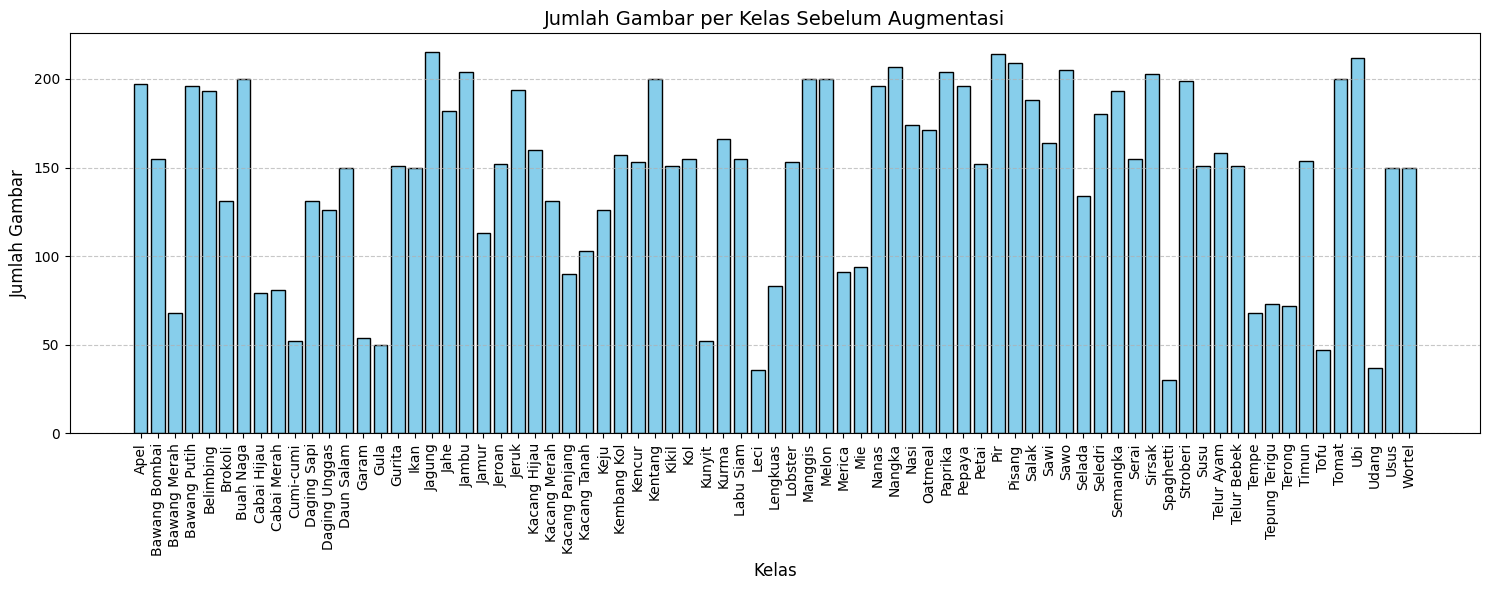

In [3]:
# Hitung jumlah gambar sebelum augmentasi
before_counts = count_images_per_class(base_dir)

# Siapkan data untuk visualisasi
all_classes = sorted(before_counts.keys())
before_values = [before_counts[cls] for cls in all_classes]

# Visualisasi: Grafik batang sebelum augmentasi
plt.figure(figsize=(15, 6))
plt.bar(all_classes, before_values, color='skyblue', edgecolor='black')
plt.title('Jumlah Gambar per Kelas Sebelum Augmentasi', fontsize=14)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Data Augmentasi**

In [86]:
# Fungsi augmentasi menggunakan TensorFlow
def augment_image(image):
    image = tf.image.resize(image, [224, 224])  # Resize hanya untuk augmentasi
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_crop(image, size=[224, 224, 3])
    image = tf.clip_by_value(image, 0.0, 255.0)
    return image.numpy().astype(np.uint8)

# List untuk mencatat file yang bermasalah
corrupted_files = []

# Proses augmentasi untuk kelas dengan jumlah gambar < 150
for class_name, count in class_counts.items():
    if count < 150:
        target_class_dir = os.path.join(augmented_data_dir, class_name)
        os.makedirs(target_class_dir, exist_ok=True)
        
        # Salin gambar asli ke folder baru
        original_class_dir = os.path.join(base_dir, class_name)
        for img_name in os.listdir(original_class_dir):
            src_path = os.path.join(original_class_dir, img_name) # Source path, merujuk ke gambar asal
            try:
                # Buka gambar
                img = Image.open(src_path).convert('RGB')
                dst_path = os.path.join(target_class_dir, img_name) # Destination Path, tujuan file hasil salinan & augmentasi
                img.save(dst_path)
            except (OSError, IOError) as e:
                print(f"Error processing {src_path}: {e}")
                corrupted_files.append(src_path)
                continue
        
        # Lakukan augmentasi
        for img_name in os.listdir(original_class_dir):
            img_path = os.path.join(original_class_dir, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img_array = np.array(img)
                for i in range(max(0, (150 - count) // count + 1)):
                    augmented_img = augment_image(img_array)
                    augmented_img_pil = Image.fromarray(augmented_img)
                    augmented_img_pil.save(os.path.join(target_class_dir, f'aug_{i}_{img_name}'))
            except (OSError, IOError) as e:
                print(f"Error processing {img_path} for augmentation: {e}")
                corrupted_files.append(img_path)
                continue

# Salin kelas dengan jumlah gambar >= 150 
for class_name, count in class_counts.items():
    if count >= 150:
        src_class_dir = os.path.join(base_dir, class_name)
        dst_class_dir = os.path.join(augmented_data_dir, class_name)
        os.makedirs(dst_class_dir, exist_ok=True)
        for img_name in os.listdir(src_class_dir):
            src_path = os.path.join(src_class_dir, img_name)
            try:
                # Buka gambar 
                img = Image.open(src_path).convert('RGB')
                dst_path = os.path.join(dst_class_dir, img_name)
                img.save(dst_path)
            except (OSError, IOError) as e:
                print(f"Error processing {src_path}: {e}")
                corrupted_files.append(src_path)
                continue

print("Augmentasi dan salinan selesai. Data disimpan di:", augmented_data_dir)
if corrupted_files:
    print("File bermasalah (tidak diproses):")
    for file in corrupted_files:
        print(file)

Error processing Food_ingredients_image/Bahan\Jeroan\__opt__aboutcom__coeus__resources__content_migration__serious_eats__seriouseats.com__recipes__images__20100301-nastybits-rawheart1-3bca311f0a504653bb78621e6522c58c.jpg: [Errno 2] No such file or directory: 'Food_ingredients_image/augmented_food_ingredients\\Jeroan\\__opt__aboutcom__coeus__resources__content_migration__serious_eats__seriouseats.com__recipes__images__20100301-nastybits-rawheart1-3bca311f0a504653bb78621e6522c58c.jpg'
Error processing Food_ingredients_image/Bahan\Kurma\istockphoto-1319252290-612x612.jpg.crdownload.jpg: image file is truncated (3 bytes not processed)
Error processing Food_ingredients_image/Bahan\Kurma\istockphoto-1474800322-612x612.jpg.crdownload.jpg: image file is truncated (5 bytes not processed)
Error processing Food_ingredients_image/Bahan\Kurma\istockphoto-825367816-612x612.jpg.crdownload.jpg: image file is truncated (7 bytes not processed)
Augmentasi dan salinan selesai. Data disimpan di: Food_ingre

## **Cek hasil data setelah augmentasi**

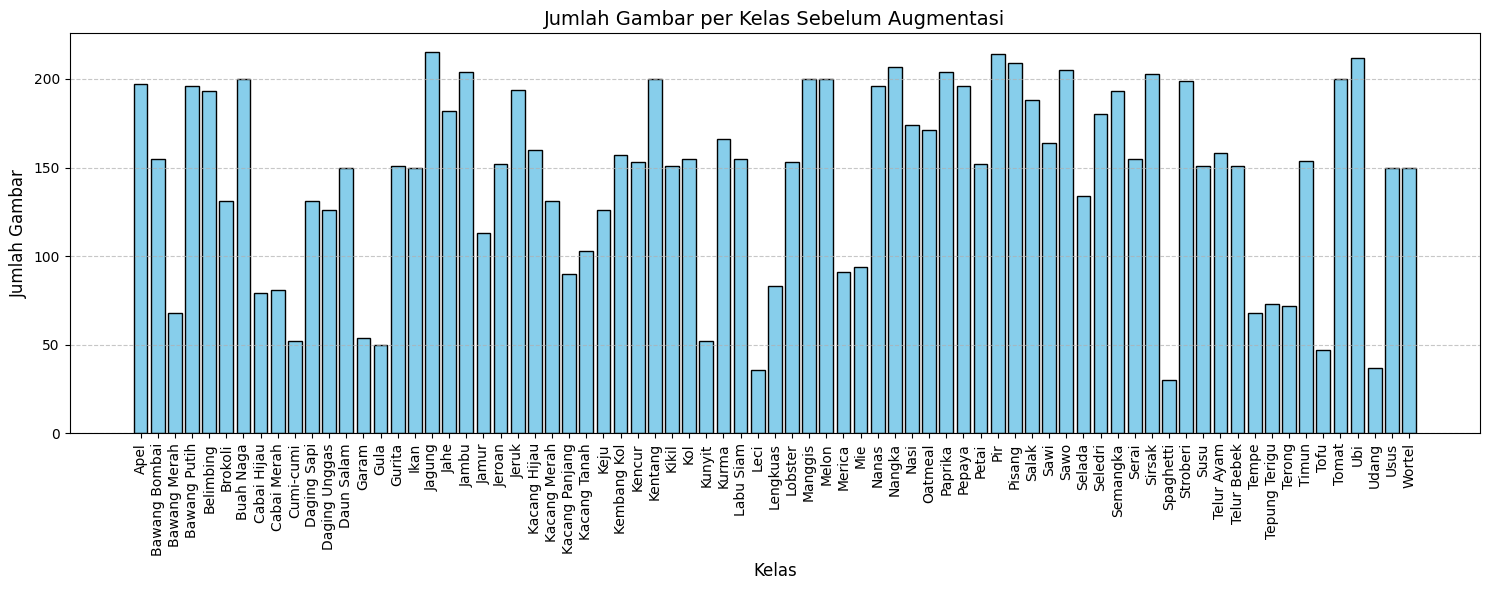

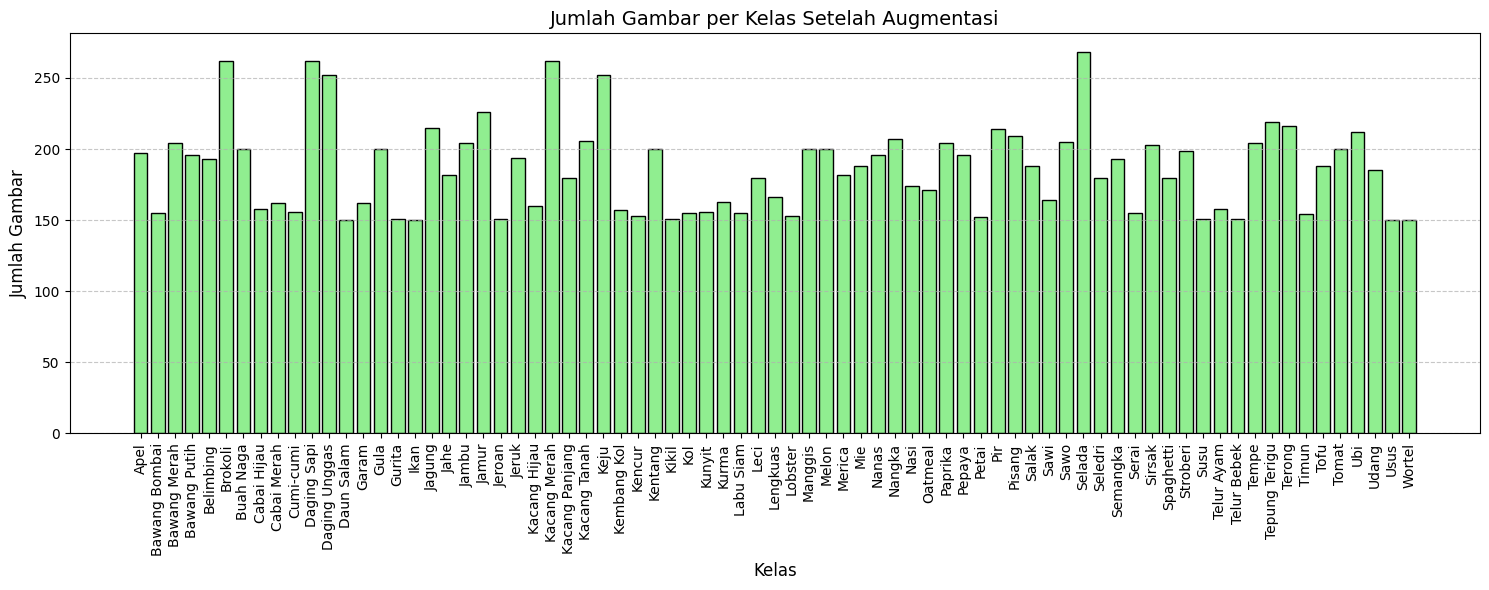

In [87]:
# Hitung jumlah gambar sebelum dan sesudah augmentasi
before_counts = count_images_per_class(base_dir)
after_counts = count_images_per_class(augmented_data_dir)

# Pastikan semua kelas ada di kedua dictionary
all_classes = sorted(set(before_counts.keys()).union(set(after_counts.keys())))
before_values = [before_counts.get(cls, 0) for cls in all_classes]
after_values = [after_counts.get(cls, 0) for cls in all_classes]

# Visualisasi: Grafik batang sebelum augmentasi
plt.figure(figsize=(15, 6))
plt.bar(all_classes, before_values, color='skyblue', edgecolor='black')
plt.title('Jumlah Gambar per Kelas Sebelum Augmentasi', fontsize=14)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Visualisasi: Grafik batang sesudah augmentasi
plt.figure(figsize=(15, 6))
plt.bar(all_classes, after_values, color='lightgreen', edgecolor='black')
plt.title('Jumlah Gambar per Kelas Setelah Augmentasi', fontsize=14)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

## **Membagi Dataset Menjadi Train, Test, dan Validation**

In [ ]:
# Membuat direktori untuk train, validation, dan test
train_dir = 'Food_ingredients_image/train'
val_dir = 'Food_ingredients_image/validation'
test_dir = 'Food_ingredients_image/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Membagi dataset
for class_name in os.listdir(augmented_data_dir):
    class_dir = os.path.join(augmented_data_dir, class_name)
    if os.path.isdir(class_dir):
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
        
        # Pisahkan menjadi train (70%) dan sisanya (30%)
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42, stratify=[class_name] * len(images))
        
        # Dari 30% sisanya, bagi menjadi validation (15%) dan test (15%)
        # 0.5 dari 30% = 15% dari total dataset
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42, stratify=[class_name] * len(temp_images))

        # Salin ke direktori masing-masing
        for img in train_images:
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            shutil.copy(img, os.path.join(train_dir, class_name))
        for img in val_images:
            os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
            shutil.copy(img, os.path.join(val_dir, class_name))
        for img in test_images:
            os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
            shutil.copy(img, os.path.join(test_dir, class_name))

print("Dataset berhasil dibagi menjadi train (70%), validation (15%), dan test (15%).")

In [89]:
# Membuat direktori untuk train, validation, dan test
train_dir = 'Food_ingredients_image/split/train'
val_dir = 'Food_ingredients_image/split/validation'
test_dir = 'Food_ingredients_image/split/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Membagi dataset
for class_name in os.listdir(augmented_data_dir):
    class_dir = os.path.join(augmented_data_dir, class_name)
    if os.path.isdir(class_dir):
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
        # Memisahkan menjadi train+val (80%) dan test (20%)
        train_val_images, test_images = train_test_split(images, test_size=0.2, random_state=42, stratify=[class_name] * len(images))
        # Pisahkan train (80%) dan val (10%) dari train_val
        train_images, val_images = train_test_split(train_val_images, test_size=0.125, random_state=42)  # 0.125 dari 80% ≈ 10% dari total

        # Menyalin ke direktori masing-masing
        for img in train_images:
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            shutil.copy(img, os.path.join(train_dir, class_name))
        for img in val_images:
            os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
            shutil.copy(img, os.path.join(val_dir, class_name))
        for img in test_images:
            os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
            shutil.copy(img, os.path.join(test_dir, class_name))

print("Dataset berhasil dibagi menjadi train, validation, dan test.")

Dataset berhasil dibagi menjadi train, validation, dan test.
